## Block 0 — Install (optional) & Imports / Config

In [1]:
import os
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Reproducibility (CUDA)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Device: cpu


## Block 1 — Load Dataset

In [2]:
DATA_PATH = "spam.csv"

df = pd.read_csv(DATA_PATH, encoding='latin')

# Expecting columns: "label" (ham/spam) and "text"
print(df.head())
print("\nColumns:", df.columns.tolist())

df = df.rename(columns={
    "v1": "label",
    "v2": "text"
})

df = df[["label", "text"]]

# Map labels to numeric
label_map = {"ham": 0, "spam": 1}
df["label_id"] = df["label"].map(label_map)



print("\nLabel distribution:")
print(df["label"].value_counts())
print("\nTotal samples:", len(df))


     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

Columns: ['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

Label distribution:
label
ham     4825
spam     747
Name: count, dtype: int64

Total samples: 5572


## Block 2 — EDA (Exploratory Data Analysis)

=== Class Distribution (counts & percentages) ===
       count  percentage
label                   
ham     4825       86.59
spam     747       13.41

=== Message Length Statistics (overall) ===
count    5572.00
mean       80.12
std        59.69
min         2.00
25%        36.00
50%        61.00
75%       121.00
max       910.00
Name: length, dtype: float64

=== Message Length by Class ===
        count    mean    std   min    25%    50%    75%    max
label                                                         
ham    4825.0   71.02  58.02   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.87  29.18  13.0  132.5  149.0  157.0  224.0

=== Length Summary by Class ===
       avg_length  median_length  min_length  max_length
label                                                   
ham         71.02           52.0           2         910
spam       138.87          149.0          13         224


/tmp/ipykernel_116978/2092827674.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=df["label"], palette="Set2")


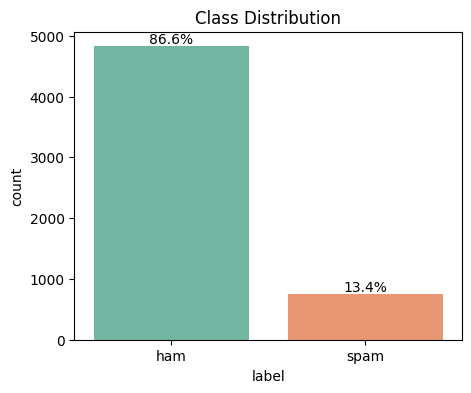

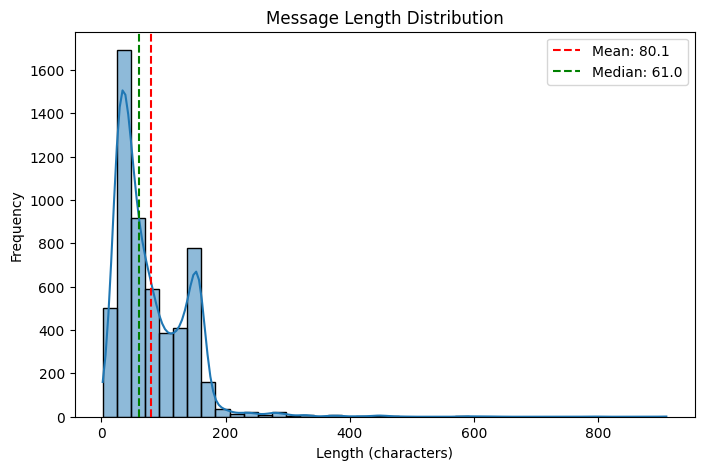

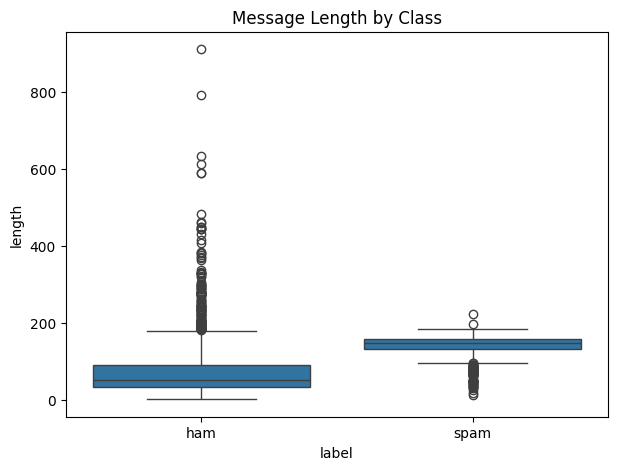


=== Sample HAM messages ===
I am late,so call you tomorrow morning.take care sweet dreams....u and me...ummifying...bye.
U r too much close to my heart. If u go away i will be shattered. Plz stay with me.
Wait  &lt;#&gt;  min..

=== Sample SPAM messages ===
Summers finally here! Fancy a chat or flirt with sexy singles in yr area? To get MATCHED up just reply SUMMER now. Free 2 Join. OptOut txt STOP Help08714742804
This is the 2nd time we have tried 2 contact u. U have won the 750 Pound prize. 2 claim is easy, call 08718726970 NOW! Only 10p per min. BT-national-rate 
Get ur 1st RINGTONE FREE NOW! Reply to this msg with TONE. Gr8 TOP 20 tones to your phone every week just å£1.50 per wk 2 opt out send STOP 08452810071 16


In [3]:
# Class distribution (counts + percentages)
class_counts = df["label"].value_counts()
class_percent = df["label"].value_counts(normalize=True) * 100

print("=== Class Distribution (counts & percentages) ===")
print(
    pd.DataFrame(
        {"count": class_counts, "percentage": class_percent.round(2)}
    )
)

# Message length
df["length"] = df["text"].apply(len)

print("\n=== Message Length Statistics (overall) ===")
print(df["length"].describe().round(2))

print("\n=== Message Length by Class ===")
print(df.groupby("label")["length"].describe().round(2))

summary = pd.DataFrame(
    {
        "avg_length": df.groupby("label")["length"].mean().round(2),
        "median_length": df.groupby("label")["length"].median().round(2),
        "min_length": df.groupby("label")["length"].min(),
        "max_length": df.groupby("label")["length"].max(),
    }
)
print("\n=== Length Summary by Class ===")
print(summary)

# Bar plot with percentages
plt.figure(figsize=(5, 4))
ax = sns.countplot(x=df["label"], palette="Set2")
plt.title("Class Distribution")

total = len(df)
for p in ax.patches:
    count = p.get_height()
    percentage = 100 * count / total
    ax.annotate(
        f"{percentage:.1f}%",
        (p.get_x() + p.get_width() / 2.0, count),
        ha="center",
        va="bottom",
    )
plt.show()

# Length histogram
plt.figure(figsize=(8, 5))
sns.histplot(df["length"], bins=40, kde=True)
plt.title("Message Length Distribution")
plt.xlabel("Length (characters)")
plt.ylabel("Frequency")

mean_len = df["length"].mean()
median_len = df["length"].median()
plt.axvline(mean_len, color="red", linestyle="--", label=f"Mean: {mean_len:.1f}")
plt.axvline(median_len, color="green", linestyle="--", label=f"Median: {median_len}")
plt.legend()
plt.show()

# Boxplot by class
plt.figure(figsize=(7, 5))
sns.boxplot(x=df["label"], y=df["length"])
plt.title("Message Length by Class")
plt.show()

# Sample messages
print("\n=== Sample HAM messages ===")
print("\n".join(df[df["label"] == "ham"]["text"].sample(3, random_state=SEED).tolist()))

print("\n=== Sample SPAM messages ===")
print("\n".join(df[df["label"] == "spam"]["text"].sample(3, random_state=SEED).tolist()))

## Block 3 — Train / Validation / Test Split

In [4]:
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df["label_id"],
    random_state=SEED,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label_id"],
    random_state=SEED,
)

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

print("\nTrain class distribution:")
print(train_df["label"].value_counts(normalize=True).round(3))

print("\nValidation class distribution:")
print(val_df["label"].value_counts(normalize=True).round(3))

print("\nTest class distribution:")
print(test_df["label"].value_counts(normalize=True).round(3))


Train size: 3900
Validation size: 836
Test size: 836

Train class distribution:
label
ham     0.866
spam    0.134
Name: proportion, dtype: float64

Validation class distribution:
label
ham     0.866
spam    0.134
Name: proportion, dtype: float64

Test class distribution:
label
ham     0.866
spam    0.134
Name: proportion, dtype: float64


# Optional Baseline — Dummy Classifier

In [5]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(train_df["text"], train_df["label_id"])

dummy_preds = dummy.predict(test_df["text"])

print("=== Dummy Classifier (Most Frequent) ===")
print(classification_report(
    test_df["label_id"],
    dummy_preds,
    target_names=["ham", "spam"]
))

=== Dummy Classifier (Most Frequent) ===
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       724
        spam       0.00      0.00      0.00       112

    accuracy                           0.87       836
   macro avg       0.43      0.50      0.46       836
weighted avg       0.75      0.87      0.80       836



/home/frederic/Documents/Jedha/Jedha/02_Data Science and Eng - Fullstack - Full-Time/X_Projects/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/frederic/Documents/Jedha/Jedha/02_Data Science and Eng - Fullstack - Full-Time/X_Projects/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/frederic/Documents/Jedha/Jedha/02_Data Science and Eng - Fullstack - Full-Time/X_Projects/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: Unde

In [6]:
# Baseline TF-IDF + Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(train_df['text'])
X_val_tfidf = tfidf.transform(val_df['text'])

lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_tfidf, train_df['label_id'])
val_preds = lr.predict(X_val_tfidf)

print("=== Baseline TF-IDF + Logistic Regression ===")
print(classification_report(val_df['label_id'], val_preds, 
                          target_names=['ham', 'spam']))

=== Baseline TF-IDF + Logistic Regression ===
              precision    recall  f1-score   support

         ham       0.99      0.98      0.99       724
        spam       0.90      0.92      0.91       112

    accuracy                           0.98       836
   macro avg       0.95      0.95      0.95       836
weighted avg       0.98      0.98      0.98       836



## Handling Class Imbalance

The dataset is clearly imbalanced, with SPAM being the minority class (i.e. 13,4%).

To address this:
- Evaluation focuses on recall and F1-score for SPAM
- Accuracy is not used as the main decision metric

Possible improvements (not applied here):
- Class-weighted loss
- Decision threshold tuning
- Oversampling techniques

In this project, transfer learning already mitigates imbalance effectively.

## Block 4 — Convert to HuggingFace Dataset

In [7]:
# Keep only the necessary columns
train_hf = Dataset.from_pandas(
    train_df[["text", "label_id"]].reset_index(drop=True)
)
val_hf = Dataset.from_pandas(
    val_df[["text", "label_id"]].reset_index(drop=True)
)
test_hf = Dataset.from_pandas(
    test_df[["text", "label_id"]].reset_index(drop=True)
)

print(train_hf)
print(val_hf)
print(test_hf)

Dataset({
    features: ['text', 'label_id'],
    num_rows: 3900
})
Dataset({
    features: ['text', 'label_id'],
    num_rows: 836
})
Dataset({
    features: ['text', 'label_id'],
    num_rows: 836
})


## Block 5 — Tokenizer & Preprocessing

In [8]:
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 64  # based on EDA (length distribution)

def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )

encoded_train = train_hf.map(preprocess_function, batched=True)
encoded_val = val_hf.map(preprocess_function, batched=True)
encoded_test = test_hf.map(preprocess_function, batched=True)

# Set the format for PyTorch
encoded_train = encoded_train.rename_column("label_id", "labels")
encoded_val = encoded_val.rename_column("label_id", "labels")
encoded_test = encoded_test.rename_column("label_id", "labels")

encoded_train.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)
encoded_val.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)
encoded_test.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "labels"],
)

print(encoded_train[0])

Map:   0%|          | 0/3900 [00:00<?, ? examples/s]

Map:   0%|          | 0/836 [00:00<?, ? examples/s]

Map:   0%|          | 0/836 [00:00<?, ? examples/s]

{'labels': tensor(1), 'input_ids': tensor([  101,  3125,   999,  9433,  1018,  1006,  2888,  1010,  1021,  1058,
         6220,  1016,  2888,  7644,  2007,  1037,  3722,  2915,  2013,  1020,
         4210,  2013,  1037,  3413,  2011, 15214, 27052,  2361,  2000,  2507,
         9433,  1037,  1016,  3125,  7785,  2044,  6275,  8117,  2015,  1012,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}


## Block 6 —  Load DistilBERT Model for Sequence Classification

## Why this model choice?

DistilBERT was selected as the main model for this project for the following reasons:

- It retains approximately 97% of BERT’s language understanding capabilities
- It is significantly lighter and faster than BERT-base
- It is well-suited for small to medium datasets
- It reduces overfitting risk compared to larger transformers

Given the SMS classification context (short texts, limited data, real-time constraints),
DistilBERT represents a strong balance between performance and computational efficiency.

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
)
model.to(DEVICE)


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSelfAttention(
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


## Block 7 — Metrics Function

In [10]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels,
        preds,
        average="binary",
        pos_label=1,
        zero_division=0,
    )

    return {
        "accuracy": acc,
        "precision_spam": precision,
        "recall_spam": recall,
        "f1_spam": f1,
    }


## Block 8 — TrainingArguments & Trainer Setup

In [11]:
# Block 8 — TrainingArguments & Trainer Setup

BATCH_SIZE = 16
N_EPOCHS = 3

training_args = TrainingArguments(
    output_dir="./outputs/transformer_att_spam",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=N_EPOCHS,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_spam",
    greater_is_better=True,
    logging_dir="./outputs/logs",
    logging_steps=50,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train,
    eval_dataset=encoded_val,
    compute_metrics=compute_metrics,
    )

`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


## Training Stability and Overfitting Considerations

Fine-tuning was limited to 3 epochs with a small learning rate (2e-5) to reduce overfitting.
Validation-based model selection was enabled via `load_best_model_at_end`.

This approach ensures:
- stable convergence
- minimal memorisation
- better generalisation on unseen messages

## Block 9 — Train Model

In [12]:
train_result = trainer.train()

print("\n=== Best model metrics on validation set ===")
metrics_val = trainer.evaluate(encoded_val)
for k, v in metrics_val.items():
    print(f"{k}: {v:.4f}")


/home/frederic/Documents/Jedha/Jedha/02_Data Science and Eng - Fullstack - Full-Time/X_Projects/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch,Training Loss,Validation Loss,Accuracy,Precision Spam,Recall Spam,F1 Spam
1,0.052467,0.047488,0.988038,0.990385,0.919643,0.953704
2,0.041785,0.051667,0.984450,0.909091,0.982143,0.944206
3,0.023216,0.035550,0.991627,0.981651,0.955357,0.968326


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/home/frederic/Documents/Jedha/Jedha/02_Data Science and Eng - Fullstack - Full-Time/X_Projects/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

/home/frederic/Documents/Jedha/Jedha/02_Data Science and Eng - Fullstack - Full-Time/X_Projects/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].
/home/frederic/Documents/Jedha/Jedha/02_Data Science and Eng - Fullstack - Full-Time/X_Projects/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)



=== Best model metrics on validation set ===


eval_loss: 0.0356
eval_accuracy: 0.9916
eval_precision_spam: 0.9817
eval_recall_spam: 0.9554
eval_f1_spam: 0.9683
eval_runtime: 27.7107
eval_samples_per_second: 30.1690
eval_steps_per_second: 1.9130
epoch: 3.0000


In [13]:
# Block 9b — Sauvegarde (après l'entraînement)
trainer.save_model("./att_spam_detector")
tokenizer.save_pretrained("./att_spam_detector")
print("Modèle sauvegardé dans ./att_spam_detector")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Modèle sauvegardé dans ./att_spam_detector


In [14]:
# ============================================================
# Block 9.5 — Evaluate TF-IDF + LR on TEST SET (for fair comparison)
# ============================================================

# Transform test data with the SAME tfidf vectorizer (fitted on train)
X_test_tfidf = tfidf.transform(test_df['text'])

# Predict on test set
test_preds_lr = lr.predict(X_test_tfidf)

print("=== Baseline TF-IDF + Logistic Regression (TEST SET) ===")
print(classification_report(
    test_df['label_id'],
    test_preds_lr,
    target_names=['ham', 'spam']
))

# Confusion matrix
cm_lr = confusion_matrix(test_df['label_id'], test_preds_lr)
print("Confusion matrix (TF-IDF/LR):")
print(cm_lr)

=== Baseline TF-IDF + Logistic Regression (TEST SET) ===
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       724
        spam       0.95      0.93      0.94       112

    accuracy                           0.98       836
   macro avg       0.97      0.96      0.96       836
weighted avg       0.98      0.98      0.98       836

Confusion matrix (TF-IDF/LR):
[[718   6]
 [  8 104]]


## Block 10 — Evaluate on Test Set

In [15]:
test_output = trainer.predict(encoded_test)
test_logits = test_output.predictions
test_labels = test_output.label_ids
test_preds = np.argmax(test_logits, axis=-1)

print("=== Classification Report (Test Set) ===")
print(classification_report(test_labels, test_preds, target_names=["ham", "spam"]))

cm = confusion_matrix(test_labels, test_preds)
print("Confusion matrix (raw counts):")
print(cm)

/home/frederic/Documents/Jedha/Jedha/02_Data Science and Eng - Fullstack - Full-Time/X_Projects/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

         ham       0.99      1.00      1.00       724
        spam       1.00      0.96      0.98       112

    accuracy                           1.00       836
   macro avg       1.00      0.98      0.99       836
weighted avg       1.00      1.00      1.00       836

Confusion matrix (raw counts):
[[724   0]
 [  4 108]]


## Block 11 — Confusion Matrix Visualization

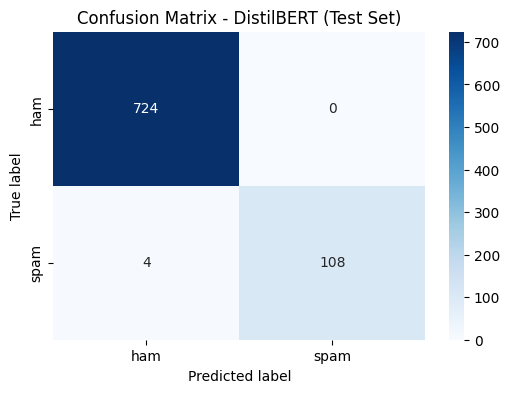

In [16]:
# ============================================================
# Block 11 — Confusion Matrix Visualization
# ============================================================

labels = ["ham", "spam"]

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.title("Confusion Matrix - DistilBERT (Test Set)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

## Block 12 — Error Analysis (Misclassified Examples)

In [17]:
# ============================================================
# Block 12 — Error Analysis (Misclassified Examples)
# ============================================================

test_texts = test_df["text"].tolist()

errors_df = pd.DataFrame(
    {
        "text": test_texts,
        "true_label": test_labels,
        "pred_label": test_preds,
    }
)

errors_df["true_label_str"] = errors_df["true_label"].map({0: "ham", 1: "spam"})
errors_df["pred_label_str"] = errors_df["pred_label"].map({0: "ham", 1: "spam"})

false_positives = errors_df[
    (errors_df["true_label"] == 0) & (errors_df["pred_label"] == 1)
]
false_negatives = errors_df[
    (errors_df["true_label"] == 1) & (errors_df["pred_label"] == 0)
]

print("=== False Positives (HAM predicted as SPAM) ===")
if len(false_positives) > 0:
    print(
        false_positives.sample(
            min(5, len(false_positives)), random_state=SEED
        )[["text", "true_label_str", "pred_label_str"]].to_string(index=False)
    )
else:
    print("No false positives in the test set.")

print("\n=== False Negatives (SPAM predicted as HAM) ===")
if len(false_negatives) > 0:
    print(
        false_negatives.sample(
            min(5, len(false_negatives)), random_state=SEED
        )[["text", "true_label_str", "pred_label_str"]].to_string(index=False)
    )
else:
    print("No false negatives in the test set.")


=== False Positives (HAM predicted as SPAM) ===
No false positives in the test set.

=== False Negatives (SPAM predicted as HAM) ===
                                                                                                  text true_label_str pred_label_str
                               For sale - arsenal dartboard. Good condition but no doubles or trebles!           spam            ham
           0A$NETWORKS allow companies to bill for SMS, so they are responsible for their \suppliers\"           spam            ham
                                Latest News! Police station toilet stolen, cops have nothing to go on!           spam            ham
Do you realize that in about 40 years, we'll have thousands of old ladies running around with tattoos?           spam            ham


## Block 13 — Interactive Demo

In [18]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "distilbert-base-uncased-finetuned-sst-2-english"  # exemple
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(DEVICE)

def predict_spam(text, model, tokenizer, max_len=64, threshold=0.5):
    """Prédiction avec seuil ajustable"""
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='pt'
    ).to(DEVICE)
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        spam_prob = probs[0, 1].item()
    
    label = "🔴 SPAM" if spam_prob > threshold else "✅ HAM"
    return label, spam_prob

# Test avec exemples variés
test_cases = [
    ("Hey, are we still on for lunch tomorrow?", "HAM"),
    ("FREE! Click here to claim your $1000 prize!", "SPAM"),
    ("Your package has been delivered. Track at: [link]", "HAM"),
    ("URGENT: Your account is locked. Call 1-800-XXX-XXXX", "SPAM"),
    ("Meeting rescheduled to 3pm in room 302", "HAM")
]

print("="*60)
print("AT&T SPAM DETECTOR - LIVE DEMO")
print("="*60)
for text, expected in test_cases:
    pred, prob = predict_spam(text, model, tokenizer)
    status = "✓" if (("SPAM" in pred and "SPAM" in expected) or 
                     ("HAM" in pred and "HAM" in expected)) else "✗"
    print(f"{status} {prob:>5.1%} | {pred:>12} | {text[:50]}...")

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

AT&T SPAM DETECTOR - LIVE DEMO
✗ 99.1% |       🔴 SPAM | Hey, are we still on for lunch tomorrow?...
✓ 97.6% |       🔴 SPAM | FREE! Click here to claim your $1000 prize!...
✗ 96.9% |       🔴 SPAM | Your package has been delivered. Track at: [link]...
✗  1.4% |        ✅ HAM | URGENT: Your account is locked. Call 1-800-XXX-XXX...
✓  4.8% |        ✅ HAM | Meeting rescheduled to 3pm in room 302...


In [19]:
# Save the template for production
trainer.save_model("./att_spam_detector")
tokenizer.save_pretrained("./att_spam_detector")
print("Modèle sauvegardé dans ./att_spam_detector")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Modèle sauvegardé dans ./att_spam_detector


## Learning curve (optional)

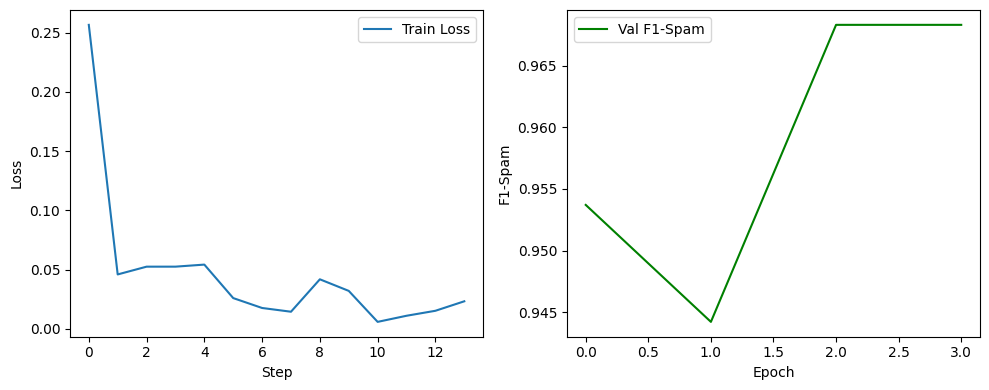

In [20]:
train_history = trainer.state.log_history
train_loss = [x['loss'] for x in train_history if 'loss' in x]
eval_f1 = [x['eval_f1_spam'] for x in train_history if 'eval_f1_spam' in x]

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Step'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(eval_f1, label='Val F1-Spam', color='green')
plt.xlabel('Epoch'); plt.ylabel('F1-Spam'); plt.legend()
plt.tight_layout()
plt.show()